In [1]:
#test the model class on JSWT simulations 
import numpy as np
import pandas as pd
#import splat
#import popsims
from astropy.coordinates import SkyCoord, Galactic
#from popsims.galaxy import Pointing, volume_calc, create_pop
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
#sns.set_style("darkgrid", {"axes.facecolor": ".95"})

#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')

from  matplotlib.colors import Normalize
import astropy.units as u
import popsims
import matplotlib
from tqdm import tqdm
from tqdm import tqdm
import matplotlib as mpl 


from popsims.simulator import Population
from popsims.galaxy import Disk, Halo
from popsims.relations import polynomial_relation
import splat.empirical as spe
import warnings


from popsims.plot_style import  plot_style
plot_style()

warnings.filterwarnings("ignore")



Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [2]:
#SDSS 
SDSS={'FOV': 2.5*u.degree*2.5*u.degree,\
      'l':((np.array([0, 360]))*u.degree.to(u.radian)),\
            'b': ((np.array([-90, 90]))*u.degree.to(u.radian))}

SDSS_discrete={'FOV': 2.5*u.degree*2.5*u.degree,\
      'l':((np.array([0, 360]))*u.degree.to(u.radian)),\
            'b': ((np.array([-90, 90]))*u.degree.to(u.radian))}

In [3]:
DATA_FOLDER='/volumes/Lacie/popsimsdata//'

In [4]:
import astropy.table as astrotable
from astropy.io.votable import parse_single_table

In [5]:
import glob

In [6]:
#forget about sdss use
ffolder='/users/caganze/research/lodieu/*.xml'
cands_vhs=[]
cands_ps1=[]
cands_ukidss=[]
for f in glob.glob('/users/caganze/research/lodieu/*UKIDSS_SDSS_*.xml'):
    tbl = parse_single_table(f).to_table()
    print('Number of candidates',len(tbl))
    cands_ukidss.append(tbl.to_pandas())
    
for f in glob.glob('/users/caganze/research/lodieu/*VHS_SDSS_*.xml'):
    tbl = parse_single_table(f).to_table()
    print('Number of candidates',len(tbl))
    cands_vhs.append(tbl.to_pandas())
    
    
for f in glob.glob('/users/caganze/research/lodieu/*VHS_PS1*.xml'):
    tbl = parse_single_table(f).to_table()
    print('Number of candidates',len(tbl))
    cands_ps1.append(tbl.to_pandas())
    
cands_vhs_df=pd.concat(cands_vhs)
cands_ps1_df=pd.concat(cands_ps1)
cands_ukidss_df=pd.concat(cands_ukidss)


dfl_conct= pd.concat([cands_vhs_df, cands_ps1_df, cands_ukidss_df])

Number of candidates 59
Number of candidates 115
Number of candidates 445
Number of candidates 253
Number of candidates 130
Number of candidates 114
Number of candidates 52
Number of candidates 13
Number of candidates 4
Number of candidates 174
Number of candidates 17
Number of candidates 2


In [7]:
def compute_mags_from_reference(spt, mag_key, ref):
    vals, unc= polynomial_relation(spt, 'spt', mag_key, ref, nsample=1, xerr=0.0)
    return np.random.normal(vals, unc)

def get_best2018_relation(spt, flt):
    return spe.typeToMag(spt, flt, ref='best2018')

def get_ps1_mags(df):
    gs= get_best2018_relation(df.spt, 'PANSTARRS_G')
    rs=compute_mags_from_reference(df.spt, 'r_ps1', 'freeser2022')
    imags=compute_mags_from_reference(df.spt, 'i_ps1', 'freeser2022')
    zs=compute_mags_from_reference(df.spt, 'z_ps1', 'freeser2022')
    ys=compute_mags_from_reference(df.spt, 'y_ps1', 'freeser2022')
    
    #use beset et al for <16
    best_gs= get_best2018_relation(df.spt, 'PANSTARRS_G')
    best_rs= get_best2018_relation(df.spt, 'PANSTARRS_R')
    best_is= get_best2018_relation(df.spt, 'PANSTARRS_I')
    best_zs= get_best2018_relation(df.spt, 'PANSTARRS_Z')
    best_ys= get_best2018_relation(df.spt, 'PANSTARRS_Y')

    #mask
    mask= df['spt']<=20

    for m, ml in zip([gs, rs, imags, zs, ys], ['G', 'R', 'I', 'Z', 'Y']):
        df['abs_PANSTARRS_{}'.format(ml)]=np.random.normal(m[0], m[1])
        df['PANSTARRS_{}'.format(ml)]=   df['abs_PANSTARRS_{}'.format(ml)]+5*np.log10(df.distance/10.0)
       
    for m, ml in zip([best_gs, best_rs, best_is, best_zs, best_ys], ['G', 'R', 'I', 'Z', 'Y']):
        df['abs_PANSTARRS_{}'.format(ml)]=np.random.normal(m[0], m[1])
        df['PANSTARRS_{}'.format(ml)]=   df['abs_PANSTARRS_{}'.format(ml)]+5*np.log10(df.distance/10.0)
        
    return df

In [8]:
sim_dat= np.load('../simulations.npy', allow_pickle=True).flatten()[0]

In [9]:
#footprint.galactic.l.radian
ukidss_sdss0= sim_dat['ukidss_sdss']
vhs_sdss= sim_dat['vhs_sdss']
vhs_ps= sim_dat['vhs_ps']

In [10]:
#run a combined ukidss-sdss 
#ukidss_sdss0= simulate_survey(['SDSS_G', 'SDSS_R','SDSS_I', 'SDSS_Z', 
#                             'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K'], \
#                             {'UKIDSS_Y': 20.3, 'UKIDSS_J': 19.9})
#Y=20.3,J=19.9,H=18.6,K=18.2
#G=23.15

In [11]:
def apply_other_cuts_ukidss(t):
    #additional cuts 
    #HJ > -0.9375*(I-J)+ 19.59375
    #J-K <= 0.125*(I-J)+ 0.4875
    #additional cuts
    # HJ >=  −2.14848* (z-J)+ 20.36963
    # J-K <= 0.2963 *(z-J)+ 0.374
    mask0= t.redH_UKIDSS_J > -0.9375*(t.SDSS_I-t.UKIDSS_J)+19.59375
    mask1= (t.UKIDSS_J-t.UKIDSS_K) <= 0.125*(t.SDSS_I-t.UKIDSS_J)+0.4875
    mask2= t.redH_UKIDSS_J > -2.14848*(t.SDSS_Z-t.UKIDSS_J)+20.36963
    mask3= (t.UKIDSS_J-t.UKIDSS_K)<=  0.2963*(t.SDSS_Z-t.UKIDSS_J)+0.374
    
    t=t[np.logical_and.reduce([mask0, mask1, mask2, mask2])]

    return t

ukidss_sdss_r= apply_other_cuts_ukidss(ukidss_sdss0)

In [12]:
len(ukidss_sdss_r), len(ukidss_sdss0)

(385162, 623291)

In [13]:
#add sdss g mag cut
ukidss_sdss=ukidss_sdss_r.query('UKIDSS_Y < 20.3 and UKIDSS_J <19.9 and UKIDSS_H < 18.6 and UKIDSS_K < 18.2  and SDSS_R < 22.2 and SDSS_I < 21.3 and SDSS_Z< 20.5 ' )

In [14]:
#ukidss_sdss=ukidss_sdss_r

In [15]:
#run a combined ukidss-sdss 
#vhs_sdss= simulate_survey(['SDSS_G', 'SDSS_R','SDSS_I', 'SDSS_Z', 
#                             'VISTA_Y', 'VISTA_J', 'VISTA_H', 'VISTA_KS'], \
#                             {'SDSS_G': 23.15})
#Y=20.3,J=19.9,H=18.6,K=18.2

In [16]:
#vhs_ps1=  simulate_survey(['VISTA_Y', 'VISTA_J', 'VISTA_H', 'VISTA_KS'], \
#                             {'VISTA_J': 19.5})

In [17]:
ukidss_sdss_thin=ukidss_sdss_r.query('population == "thin disk"').reset_index(drop=True)
ukidss_sdss_thick=ukidss_sdss_r.query('population == "thick disk"').reset_index(drop=True)
ukidss_sdss_halo=ukidss_sdss_r.query('population =="halo"').reset_index(drop=True)

In [18]:
len(ukidss_sdss_thin), len(ukidss_sdss_thick), len(ukidss_sdss_halo)

(402, 119245, 265515)

In [19]:
colors=['#AAAAAA', '#FF851B', '#0074D9']
pops=[ukidss_sdss_thin, ukidss_sdss_thick, ukidss_sdss_halo]
names=['thin disk', 'thick disk', 'halo']
sizes=[20, 30, 30]
markers=['s', '+', '*']

In [20]:
#u=22.0, g=22.2, r=22.2, i=21.3, z=20.5
vhs_sdss=vhs_sdss.query('VISTA_J < 19.5 and VISTA_H < 18.6 and VISTA_KS < 17.9 and \
SDSS_G < 22.2 and SDSS_R < 22.2 and SDSS_I < 21.3 and SDSS_Z< 20.5')

In [21]:
vhs_ps=vhs_ps.query('PANSTARRS_G < 23.3 and PANSTARRS_R < 23.2 and PANSTARRS_I < 23.1 \
and PANSTARRS_Z < 22.3 and PANSTARRS_Y < 21 and VISTA_J < 19.5 and VISTA_H < 18.6 and VISTA_KS < 17.9')

In [22]:
len(ukidss_sdss), len(ukidss_sdss0), len(ukidss_sdss_r)

(2209, 623291, 385162)

[None]

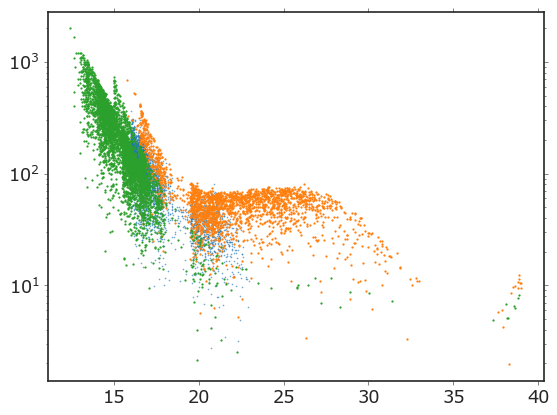

In [23]:
fig, ax=plt.subplots()

ax.scatter(vhs_ps.spt, vhs_ps.distance, s=0.1)
ax.scatter(ukidss_sdss.spt, ukidss_sdss.distance, s=1)
ax.scatter(vhs_sdss.spt, vhs_sdss.distance, s=1)
ax.set(yscale='log')


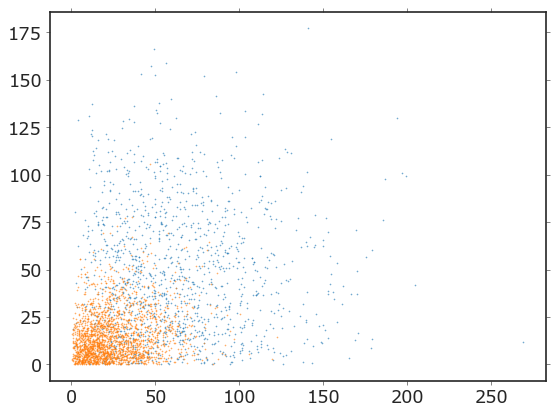

In [24]:
fig, ax=plt.subplots()
mask= vhs_ps.population=='thin disk'


ax.scatter(((vhs_ps.U**2+vhs_ps.W**2)**0.5)[~mask], np.abs(vhs_ps.V[~mask]), s=0.1)
ax.scatter(((vhs_ps.U**2+vhs_ps.W**2)**0.5)[mask], np.abs(vhs_ps.V[mask]), s=0.1)



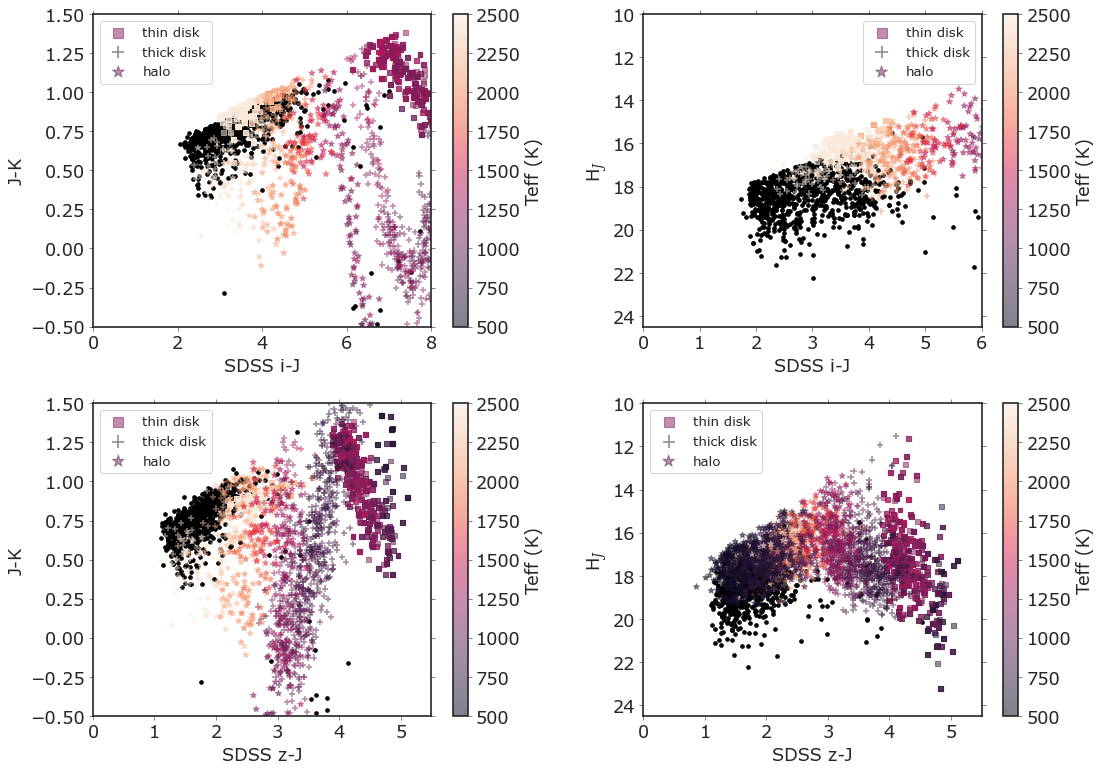

In [25]:
fig, ax=plt.subplots(ncols=2, nrows=2, figsize=(14, 10))

ax[0][0].scatter(dfl_conct.SDSSi-dfl_conct.Hmag_LAS, dfl_conct.Jmag_LAS-dfl_conct.Kmag_LAS, s=10, c='k' )
ax[0][1].scatter(dfl_conct.SDSSi-dfl_conct.Jmag_LAS, dfl_conct.Hj, s=10, c='k'  )

ax[1][0].scatter(dfl_conct.SDSSz-dfl_conct.Jmag_LAS, dfl_conct.Jmag_LAS-dfl_conct.Kmag_LAS, s=10, c='k' )
ax[1][1].scatter(dfl_conct.SDSSz-dfl_conct.Jmag_LAS, dfl_conct.Hj, s=10, c='k' )


for idx in range(0, 3):
    p= pops[idx].sample(n=1000, replace=True)
    c=colors[idx]
    n=names[idx]
    s=sizes[idx]
    m= markers[idx]

    #sns.scatterplot(p.SDSS_I-p.UKIDSS_J, p.UKIDSS_J-p.UKIDSS_K, color=c, ax=ax[0][0])
    ax[0][0].scatter(p.SDSS_I-p.UKIDSS_J, p.UKIDSS_J-p.UKIDSS_K, c=p.temperature, \
                     s=s, marker=m, label=n, alpha=0.5, vmin=500, vmax=2500)

    
    #sns.scatterplot(p.SDSS_I-p.UKIDSS_J, p.redH_UKIDSS_H,color=c, ax=ax[0][1])
    ax[0][1].scatter(p.SDSS_I-p.UKIDSS_J, p.redH_UKIDSS_H,c=p.temperature, s=s, marker=m, label=n,  \
                     alpha=0.5, vmin=500, vmax=2500)

  
    #sns.scatterplot(p.SDSS_Z-p.UKIDSS_J, p.UKIDSS_J-p.UKIDSS_K, ax=ax[1][0], color=c)
    ax[1][0].scatter(p.SDSS_Z-p.UKIDSS_J, p.UKIDSS_J-p.UKIDSS_K,  c=p.temperature, s=s, label=n,
                     marker=m, alpha=0.5, vmin=500, vmax=2500)
    
    #sns.scatterplot(p.SDSS_Z-p.UKIDSS_J, p.redH_UKIDSS_H, color=c, ax=ax[1][1])
    c=ax[1][1].scatter(p.SDSS_Z-p.UKIDSS_J, p.redH_UKIDSS_H, c=p.temperature, s=s, marker=m, label=n,\
                     alpha=0.5, vmin=500, vmax=2500)







for a in np.concatenate(ax):
    l=a.legend(fontsize=12, markerscale=2)
    plt.colorbar(c, ax=a, label='Teff (K)')
ax[0][0].set(xlabel='SDSS i-J', ylabel='J-K', xlim=[0, 8], ylim=[-0.5, 1.5])
ax[0][1].set(xlabel='SDSS i-J', ylabel=r'H$_J$',  xlim=[0, 6], ylim=[10, 24.5])
ax[0][1].invert_yaxis()

ax[1][0].set(xlabel='SDSS z-J', ylabel='J-K', xlim=[0, 5.5], ylim=[-0.5, 1.5])
ax[1][1].set(xlabel='SDSS z-J', ylabel=r'H$_J$', xlim=[0, 5.5], ylim=[10, 24.5])
ax[1][1].invert_yaxis()


plt.tight_layout()

plt.savefig('../figures/plot_simulatedcolors_sdss_ukidss.jpeg')


In [26]:
SkyCoord(*popsims.random_angles(1)*u.radian)


<SkyCoord (ICRS): (ra, dec) in deg
    [(77.46817189, -5.60253933)]>

In [27]:
## do z-J vs z mag, can also plot histogram 
###

In [28]:
POLYNOMIALS=(np.load('/users/caganze/research/popsimsdata/abs_mag_relations.npy', allow_pickle=True)).flatten()[0]

In [29]:
#random directions
ra, dec= popsims.random_angles(int(1e5))*u.radian

mask_ukidss_sdss= np.logical_and(dec.to(u.degree).value> 0,  dec.to(u.degree).value <50)

mask_vhs_sdss=dec.to(u.degree).value<0

mask_vhs_ps=mask_vhs_sdss

In [30]:
#look at random pointings
from astropy.io import ascii
t1=ascii.read('/users/caganze/ukidss_sdss_crossmatch.csv').to_pandas()
t2=ascii.read('/users/caganze/vhs_sdss_crossmatch.csv').to_pandas()
t3=ascii.read('/users/caganze/vhs_ps1_crossmatch.csv').to_pandas()

In [31]:
footprint_ukidss=SkyCoord(t1.RA*u.degree, t1.Dec*u.degree)
footprint_vhs= SkyCoord(t2.RA*u.degree, t2.Dec*u.degree)
footprint_ps1=SkyCoord(t3.RA*u.degree, t3.Dec*u.degree)

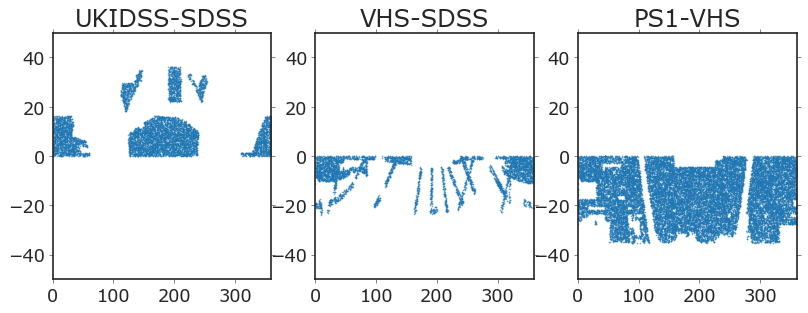

In [32]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
ax[0].scatter(t1.RA, t1.Dec, s=.1)
ax[1].scatter(t2.RA, t2.Dec, s=.1)
ax[-1].scatter(t3.RA, t3.Dec, s=.1)
for a in ax:
    a.set(xlim=[0, 360], ylim=[-50, 50])
ax[0].set(title='UKIDSS-SDSS')
ax[1].set(title='VHS-SDSS')
ax[-1].set(title='PS1-VHS')
plt.savefig('../figures/plot_simulatedareas.pdf')

In [33]:
a0=(len(t1)/len(ra.to(u.degree)[mask_ukidss_sdss]))*\
(np.ptp(dec.to(u.degree)[mask_ukidss_sdss].value))*(np.ptp(dec.to(u.degree)[mask_ukidss_sdss].value))

In [34]:
a1=(len(t2)/len(ra.to(u.degree)[mask_vhs_sdss]))*\
(np.ptp(dec.to(u.degree)[mask_vhs_sdss].value))*(np.ptp(dec.to(u.degree)[mask_vhs_sdss].value))

In [35]:
a2=(len(t3)/len(ra.to(u.degree)[mask_vhs_sdss]))*\
(np.ptp(dec.to(u.degree)[mask_vhs_sdss].value))*(np.ptp(dec.to(u.degree)[mask_vhs_sdss].value))

In [36]:
#comon area according to the paper 3667, 1681 and 7692 square degrees fo
# UKIDSS-SDSS, VHS-SDSS and VHS-PS, respectively 
#a1=3667
#a2=1681
#a3=7692

In [62]:
print ('area UKIDSS-SDSS', a0)
print ('area VHS-SDSS', a1)
print ('area PS1-VHS', a2)

area UKIDSS-SDSS 494.82122028051816
area VHS-SDSS 756.1773957416674
area PS1-VHS 3675.1279023808315


In [38]:
AREA_UKIDSS_SDSS=a0*(u.degree**2).to(u.radian**2)*(u.radian**2)
AREA_VHS_SDSS=a1*(u.degree**2).to(u.radian**2)*(u.radian**2)
AREA_VHS_PS1=a2*(u.degree**2).to(u.radian**2)*(u.radian**2)
NSIGHTS=10_000

In [39]:
def compute_vols_and_numbers(df, gmodel, sptgrid,  footprint, maglimits, kind='dwarfs'):
    counts={}
    vols={}
    dists={}

    for spt in sptgrid:
        
        dmins=[]
        dmaxs=[]
        
        dmins_sd=[]
        dmaxs_sd=[]
        
        for k in maglimits.keys():
            mag_cut= maglimits[k]
            absmag= np.poly1d(POLYNOMIALS['absmags_spt'][kind][k]['fit'])(spt)
            
            #absmag_sd= np.poly1d(POLYNOMIALS['absmags_spt']['subdwarfs'][k]['fit'])(spt)
        
            mag_cut= maglimits[k]
            
            dmin=10.**(-(absmag-mag_cut[0])/5. + 1.)
            dmax=10.**(-(absmag-mag_cut[1])/5. + 1.)
            
            #dmin_sd=10.**(-(absmag_sd-14)/5. + 1.)
            #dmax_sd=10.**(-(absmag_sd-mag_cut)/5. + 1.)
        
            
            dmins.append(dmin)
            dmaxs.append(dmax)
            
            #dmins_sd.append(dmin)
            #dmaxs_sd.append(dmax)
            
        dmin=np.nanmedian(dmins)
        dmax=np.nanmedian(dmaxs)
        
        #dmin_sd=np.nanmedian(dmins_sd)
        #dmax_sd=np.nanmedian(dmaxs_sd)
        
        #print (spt, dmin, dmax)
        #print (df)
        #print (df.scale)
        scale=[df.scale.mean(), df.scale_unc.mean(), df.scale_times_model.mean()]
        
        sn= len(df)
        #sn= len(df.query('population == "thin disk"'))
        #snt= len(df.query('population == "thick disk"'))
        #snh= len(df.query('population == "halo"'))
      
        sn_c= len(df.query('spt < {}'.format(spt, spt+0.9)))
        #snt_c= len(df.query('population == "thick disk" and spt >= {} and spt < {}'.format(spt, spt+0.9)))
        #snh_c= len(df.query('population == "halo" and spt >= {} and spt < {}'.format(spt, spt+0.9)))
        
        
        volumes={'volume': 0.0}
        
        cnts={'number':  sn_c*np.divide(scale[-1], sn)}
        for s in  footprint:
            l=s.galactic.l.radian
            b=s.galactic.b.radian
            volumes['volume'] += gmodel.volume(l, b, dmin, dmax)
            
        vols.update({spt: volumes})
        counts.update({spt: cnts})
        dists.update({spt: dmax})
        
        
    return pd.DataFrame.from_records(vols).T.replace(np.inf, np.nan),\
    pd.DataFrame.from_records(counts).T.replace(np.inf, np.nan),\
    dists


In [40]:
a1

756.1773957416674

In [41]:
#scale factors --> scale arrays by number of small pointings of 0.1 deg in given directions

In [42]:
##can do three selections and color them by temperature?
sptgrid=np.arange(14, 40)

In [43]:
footprint_vhs[:10]

<SkyCoord (ICRS): (ra, dec) in deg
    [( 36.3132047 ,  -5.15016644), ( 39.03895046,  -2.50443067),
     (315.77783844,  -7.86664526), (213.50686958, -19.48338129),
     (  8.90817941, -22.64027858), ( 23.12499888, -10.17377407),
     ( 18.08453611,  -7.51828702), (335.59119785,  -9.72689974),
     ( 13.47778162,  -9.95183981), (116.94675401,  -1.29717067)]>

In [44]:
len(vhs_sdss) #these are the things we lost), len(vhs_ps), len(ukidss_sdss)

4706

In [45]:
#initial length

In [46]:
#volume: integrate to the largest volume then correct it by the fraction of actual
#detectable sources in that volume --> which is your selection function, so keep track of that fraction of \
#"lost sources"
#the color selection 
# --> are counting the selection function twice ?--> well if you bin the selected objects then no problemo
# --> makes my problem worse because the numbers are larger

In [47]:
res_ukidss_sdss={'thin_disk': compute_vols_and_numbers(ukidss_sdss, Disk(), \
                                                               sptgrid, footprint_ukidss[:NSIGHTS], {'SDSS_G': [1, 22.2]}), 
                 
                'thick_disk': compute_vols_and_numbers(ukidss_sdss, Disk(H=900, L=3600),\
                                                                sptgrid, footprint_ukidss[:NSIGHTS], {'SDSS_G': [1, 22.2]}, \
                                                      kind='subdwarfs'),
                 
                'halo': compute_vols_and_numbers(ukidss_sdss, Halo(), \
                                                                sptgrid,  footprint_ukidss[:NSIGHTS], {'SDSS_G': [1, 22.2]},
                                                 kind='esd')}

In [48]:
res_vhs_sdss={'thin_disk': compute_vols_and_numbers(vhs_sdss, Disk(), \
                                                               sptgrid, \
                                                    footprint_vhs[:NSIGHTS],  {'SDSS_Z': [1, 20.5]}),
                 
                'thick_disk': compute_vols_and_numbers(vhs_sdss, Disk(H=900, L=3600),\
                                                                sptgrid, footprint_vhs[:NSIGHTS],\
                                                       {'SDSS_Z': [1, 20.5]},
                                                      kind='subdwarfs'),
                 
                'halo': compute_vols_and_numbers(vhs_sdss, Halo(), \
                                                                sptgrid, footprint_vhs[:NSIGHTS],\
                                                 {'SDSS_Z': [1, 20.5]},
                                                 kind='esd')}

In [49]:
#res_vhs_sdss

In [50]:
res_vhs_ps1={'thin_disk': compute_vols_and_numbers(vhs_ps, Disk(), \
                                                               sptgrid,  footprint_ps1[:NSIGHTS],\
                                                   {'SDSS_G': [1, 23.3]}), 
                 
                'thick_disk': compute_vols_and_numbers(vhs_ps, Disk(H=900, L=3600),\
                                                                sptgrid,\
                                                       footprint_ps1[:NSIGHTS],
                                                       {'SDSS_G': [1, 23.3]}, \
                                                      kind='dwarfs'),
                 
                'halo': compute_vols_and_numbers(vhs_ps, Halo(), \
                                                                sptgrid, \
                                                 footprint_ps1[:NSIGHTS],
                                                 {'SDSS_G': [1, 23.3]},
                                                 kind='dwarfs')}

In [61]:
AREA_UKIDSS_SDSS

<Quantity 0.15073116 rad2>

In [51]:
#POINTING_AREA_UKIDSS=(AREA_UKIDSS_SDSS.to(u.degree**2))/len(footprint_ukidss) #making sure they're not overlapping !
sc_fac_ukidss=AREA_UKIDSS_SDSS.to(u.radian**2)/NSIGHTS

sc_fac_vhs=AREA_VHS_SDSS.to(u.radian**2)/NSIGHTS

sc_fac_ps1=AREA_VHS_PS1.to(u.radian**2)/NSIGHTS


In [52]:

scale_factors={'thin_disk':1, 'thick_disk': 0.12, 'halo': 0.005} #scale factors for pops


linestyles={'thin_disk': '-',
           'thick_disk': '--',
           'halo': 'dotted'}

colors_dict={'thin_disk': '#AAAAAA', \
             'thick_disk': '#FF851B',\
             'halo':'#0074D9'}

In [53]:
from scipy.interpolate import griddata

def invert_rel(p, yvalues):
    xgrid=np.linspace(*p['range'], 100000)
    #invert
    ygrid= np.poly1d(p['fit'])(xgrid)
    #look up 
    f=lambda y: griddata(ygrid,xgrid, yvalues, fill_value=np.nan, method='linear', rescale=True)
    return f(yvalues)

In [79]:
p0=POLYNOMIALS['colors_spt']['subdwarfs']['SDSS_ZandUKIDSS_J']
p1=POLYNOMIALS['colors_spt']['subdwarfs']['SDSS_ZandVISTA_J']
p2=POLYNOMIALS['colors_spt']['subdwarfs']['PANSTARRS_ZandVISTA_J']

In [81]:
p2['range']

(15, 39)

In [82]:
sptgrid=np.arange(15, 40)
spts_ukidss=np.histogram(invert_rel(p0, -(cands_ukidss_df.Jmag_LAS-cands_ukidss_df.SDSSz).values), bins=sptgrid)

spts_vhs=np.histogram(invert_rel(p1, (cands_vhs_df.SDSSz-cands_vhs_df.Jmag_VHS).values), bins=sptgrid)

spts_ps1=np.histogram(invert_rel(p2, (cands_ps1_df.PSz-cands_ps1_df.Jmag_VHS).values), bins=sptgrid)

spts_ukidss

(array([282, 159,  64,  13,   9,   2,   1,   1,   2,   1,   1,   3,   2,
          3,   2,   0,   1,   1,   0,   1,   2,   0,   0,   0]),
 array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39]))

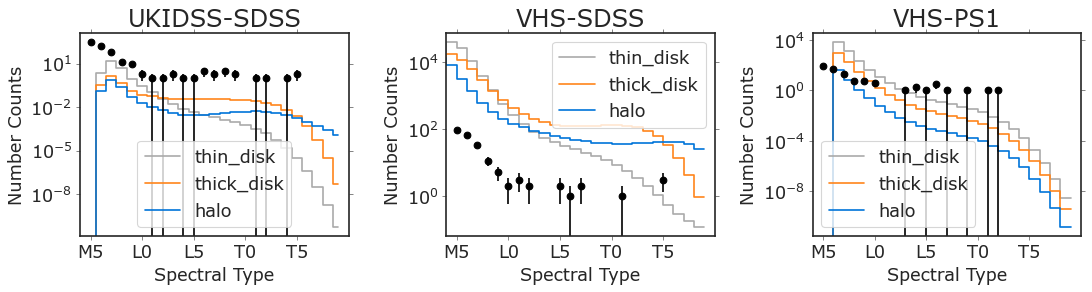

In [91]:

fig, ax=plt.subplots(figsize=(14, 4), ncols=3)

for m in ['thin_disk', 'thick_disk', 'halo']:
    c= colors_dict[m]
    sc0=scale_factors[m]*sc_fac_ukidss
    sc1=scale_factors[m]*sc_fac_vhs
    sc2=scale_factors[m]*sc_fac_ps1
    
    ax[0].step(res_ukidss_sdss[m][0].index, \
   sc0*res_ukidss_sdss[m][0].volume*res_ukidss_sdss[m][1].number,\
        color=c,  linestyle='-', label=m, where='mid')
    
    ax[1].step(res_vhs_sdss[m][0].index, \
   sc1*res_vhs_sdss[m][0].volume*res_vhs_sdss[m][1].number,\
        color=c,  linestyle='-', label=m)
    
    ax[-1].step(res_vhs_ps1[m][0].index, \
   sc2*res_vhs_ps1[m][0].volume*res_vhs_ps1[m][1].number,\
        color=c,  linestyle='-', label=m)
    
ax[0].errorbar(spts_ukidss[1][:-1], spts_ukidss[0], yerr=np.sqrt(spts_ukidss[0]), fmt='o', color='k')
ax[1].errorbar(spts_vhs[1][:-1], spts_vhs[0], yerr=np.sqrt(spts_vhs[0]), fmt='o', color='k')
ax[-1].errorbar(spts_ps1[1][:-1], spts_ps1[0], yerr=np.sqrt(spts_ps1[0]), fmt='o', color='k')

for a in ax:
    a.legend()
    a.set(xticks=[15,20, 25, 30, 35], xticklabels=['M5', 'L0', 'L5', 'T0', 'T5'],\
          xlim=[14, 40], yscale='log')
    a.yaxis.set_tick_params(labelbottom=True)
    
ax[0].set(ylabel=r'Number Counts',\
       xlabel='Spectral Type', title='UKIDSS-SDSS')

ax[1].set(yscale='log', ylabel='Number Counts',\
       xlabel='Spectral Type', title='VHS-SDSS')

ax[-1].set(yscale='log', ylabel='Number Counts',\
       xlabel='Spectral Type', title='VHS-PS1')


plt.tight_layout()
plt.savefig('../figures/plot_simulatedncounts.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


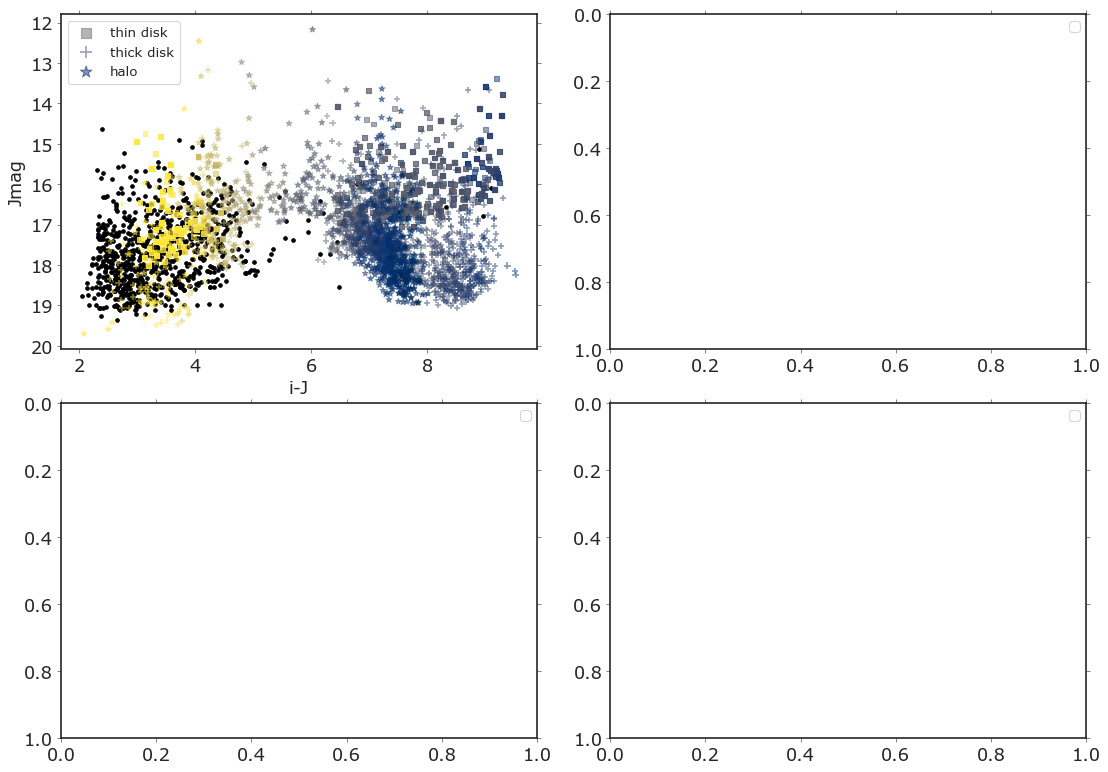

In [90]:
fig, ax=plt.subplots(ncols=2, nrows=2, figsize=(14, 10))

ax[0][0].scatter(dfl_conct.SDSSi-dfl_conct.Hmag_LAS, dfl_conct.Jmag_LAS, s=10, c='k' )



for idx in range(0, 3):
    p= pops[idx].sample(n=1000, replace=True)
    c=colors[idx]
    n=names[idx]
    s=sizes[idx]
    m= markers[idx]

    #sns.scatterplot(p.SDSS_I-p.UKIDSS_J, p.UKIDSS_J-p.UKIDSS_K, color=c, ax=ax[0][0])
    ax[0][0].scatter(p.SDSS_I-p.UKIDSS_J, p.UKIDSS_J, c=p.temperature, \
                     s=s, marker=m, label=n, alpha=0.5, vmin=500, vmax=2500, cmap='cividis')

    
    #sns.scatterplot(p.SDSS_I-p.UKIDSS_J, p.redH_UKIDSS_H,color=c, ax=ax[0][1])
    #ax[0][1].scatter(p.SDSS_I-p.UKIDSS_J, p.redH_UKIDSS_H,c=p.temperature, s=s, marker=m, label=n,  \
    #                 alpha=0.5, vmin=500, vmax=2500)

  
    #sns.scatterplot(p.SDSS_Z-p.UKIDSS_J, p.UKIDSS_J-p.UKIDSS_K, ax=ax[1][0], color=c)
    #ax[1][0].scatter(p.SDSS_Z-p.UKIDSS_J, p.UKIDSS_J-p.UKIDSS_K,  c=p.temperature, s=s, label=n,
    #                 marker=m, alpha=0.5, vmin=500, vmax=2500)
    
    #sns.scatterplot(p.SDSS_Z-p.UKIDSS_J, p.redH_UKIDSS_H, color=c, ax=ax[1][1])
    #c=ax[1][1].scatter(p.SDSS_Z-p.UKIDSS_J, p.redH_UKIDSS_H, c=p.temperature, s=s, marker=m, label=n,\
    #                 alpha=0.5, vmin=500, vmax=2500)







for a in np.concatenate(ax):
    l=a.legend(fontsize=12, markerscale=2)
    #plt.colorbar(c, ax=a, label='Teff (K)')
    a.invert_yaxis()


plt.tight_layout()

ax[0][0].set(ylabel='Jmag', xlabel='i-J')
plt.savefig('../figures/plot_colors_mags_sdss_ukidss.jpeg')
